# SETUP

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/jax_learn_to_learn")

In [ ]:
!pip3 install git+https://github.com/deepmind/dm-haiku

In [ ]:
import haiku as hk

import jax
import jax.numpy as jnp
from jax import grad, jit, value_and_grad
import jax.experimental.optimizers as optimizers
import jax.random as random
import jax.lax as lax
import jax.nn as nn

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [ ]:
key = random.PRNGKey(16892)

# LSTM Optimizer

In [ ]:
hidden_sz = 20

In [ ]:
def _lstm(x, prev_state_1, prev_state_2):
  fc1 = hk.Linear(hidden_sz, name = 'fc1')
  lstm1 = hk.LSTM(hidden_sz, name = 'lstm1')
  lstm2 = hk.LSTM(hidden_sz, name = 'lstm2')
  fc2 = hk.Linear(1, name = 'fc2')

  x = nn.relu(fc1(x))
  
  h_1, state_1 = lstm1(x, prev_state_1)
  h_2, state_2 = lstm2(h_1, prev_state_2)

  return fc2(h_2), state_1, state_2

lstm = hk.without_apply_rng(hk.transform(_lstm))

def lstm_forward(lstm_params, x, prev_state_1, prev_state_2):
  return lstm.apply(lstm_params, x, prev_state_1, prev_state_2)

# Gradient Preprocessing

In [ ]:
def preproc_raw(g):
  return g

def preproc_log(g):
  return jnp.sign(g)*jnp.minimum(jnp.log1p(jnp.abs(g)) / 10.0, 1)

# Quadratic

In [ ]:
train_sz = 400
outer_steps = 5
inner_steps = 20
val_sz = 100
val_steps = (outer_steps * inner_steps) * 2
test_sz = 100
test_steps = (outer_steps * inner_steps) * 2
dim = 10

TEST_STEPS = test_steps
INNER_STEPS = inner_steps

In [ ]:
# Quadratic Dataset
train_W = []
train_y = []
train_theta = []
val_W = []
val_y = []
val_theta = []
test_W = []
test_y = []
test_theta = []

for i in range(train_sz):
  key, subkey1, subkey2, subkey3 = random.split(key, 4)
  W = random.normal(subkey1, (dim, dim))
  y = random.normal(subkey2, (dim,))
  theta = random.normal(subkey3, (dim,))
  train_W.append(W)
  train_y.append(y)
  train_theta.append(theta)

for i in range(val_sz):
  key, subkey1, subkey2, subkey3 = random.split(key, 4)
  W = random.normal(subkey1, (dim, dim))
  y = random.normal(subkey2, (dim,))
  theta = random.normal(subkey3, (dim,))
  val_W.append(W)
  val_y.append(y)
  val_theta.append(theta)

for i in range(test_sz):
  key, subkey1, subkey2, subkey3 = random.split(key, 4)
  W = random.normal(subkey1, (dim, dim))
  y = random.normal(subkey2, (dim,))
  theta = random.normal(subkey3, (dim,))
  test_W.append(W)
  test_y.append(y)
  test_theta.append(theta)

In [ ]:
@jit
def quadratic_forward(theta, W, y):
  y_hat = W @ theta
  return jnp.sum((y - y_hat) ** 2), y_hat

vag_quadratic_forward = value_and_grad(quadratic_forward, has_aux=True)

# Quadratic ADAM

In [ ]:
@jit
def quadratic_adam_step(step, opt_state, W, y, lr):
  (loss_quadratic, _), grads_quadratic = vag_quadratic_forward(get_params(opt_state), W, y)
  _, opt_update, _ = optimizers.adam(lr)
  opt_state = opt_update(step, grads_quadratic, opt_state)
  return opt_state, loss_quadratic
@jit
def quadratic_adam_f(carry,i):
  opt_state, loss_quadratic = quadratic_adam_step(i, carry[0], carry[1], carry[2], carry[3])
  carry = [opt_state, carry[1], carry[2], carry[3]]
  return carry, loss_quadratic

@jit
def quadratic_adam_update_scan(opt_state, W, y, lr):
  idx = jnp.arange(0, TEST_STEPS)
  init = [opt_state, W, y, lr]
  [new_opt_state, _, _, _], losses_quadratic = lax.scan(quadratic_adam_f, init, idx)
  return new_opt_state, losses_quadratic

In [ ]:
# ADAM
lrs = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

quadratic_adam_losses_avgs = []

for lr in lrs:
  quadratic_adam_losses_avg = None
  opt_init, opt_update, get_params = optimizers.adam(lr)

  for i in range(test_sz):
    W = test_W[i]
    y = test_y[i]
    theta = test_theta[i]
    opt_state = opt_init(theta)
    opt_state, losses_quadratic = quadratic_adam_update_scan(opt_state, W, y, lr)
    
    if quadratic_adam_losses_avg is None:
      quadratic_adam_losses_avg = jnp.array(losses_quadratic)
    else:
      quadratic_adam_losses_avg += jnp.array(losses_quadratic)

  quadratic_adam_losses_avg /= test_sz
  quadratic_adam_losses_avgs.append(quadratic_adam_losses_avg)

Learning Rate: 0.005
Initial Loss Mean: 111.65217
Final Loss Mean: 19.368307
-----------------------------
Learning Rate: 0.01
Initial Loss Mean: 111.65217
Final Loss Mean: 5.732089
-----------------------------
Learning Rate: 0.05
Initial Loss Mean: 111.65217
Final Loss Mean: 0.9149091
-----------------------------
Learning Rate: 0.1
Initial Loss Mean: 111.65217
Final Loss Mean: 0.6459342
-----------------------------
Learning Rate: 0.5
Initial Loss Mean: 111.65217
Final Loss Mean: 0.3132111
-----------------------------
Learning Rate: 1.0
Initial Loss Mean: 111.65217
Final Loss Mean: 0.26147392
-----------------------------


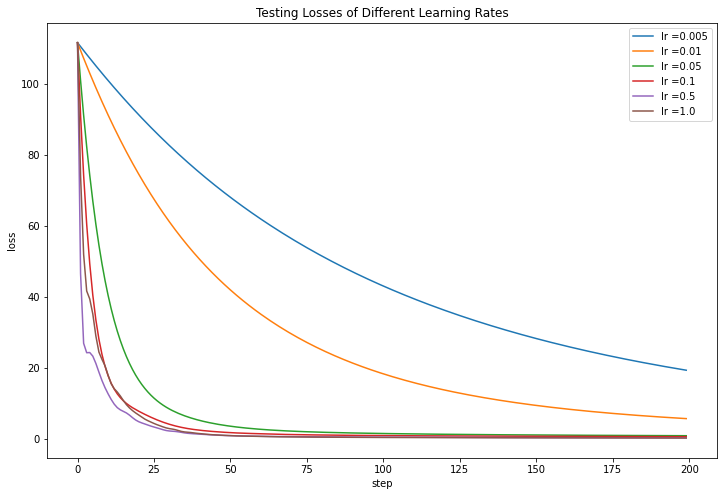

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Testing Losses of Different Learning Rates')
plt.ylabel('loss')
plt.xlabel('step')
for i in range(len(lrs)):
  print('Learning Rate:', lrs[i])
  print('Initial Loss Mean:', quadratic_adam_losses_avgs[i][0])
  print('Final Loss Mean:', quadratic_adam_losses_avgs[i][-1])
  print('-----------------------------')
  plt.plot(quadratic_adam_losses_avgs[i],label= 'lr =' + str(lrs[i]))
plt.legend()

# Quadratic LSTM

In [ ]:
@jit
def quadratic_lstm_inner_f(carry, i):
  (loss_quadratic, _), grads_quadratic = vag_quadratic_forward(carry[3], carry[4], carry[5])
  grads_quadratic = preproc_raw(grads_quadratic)
  delta_quadratic, carry[1], carry[2] = lstm_forward(carry[0], grads_quadratic[:,None], carry[1], carry[2])
  carry[3] = carry[3] + jnp.squeeze(delta_quadratic, 1)
  return carry, loss_quadratic

@jit
def quadratic_lstm_inner_scan(lstm_params, prev_state_1, prev_state_2, theta, W, y):
  init = [lstm_params, prev_state_1, prev_state_2, theta, W, y]
  idx = jnp.arange(0, INNER_STEPS)
  [_, prev_state_1, prev_state_2, theta, _, _], losses_quadratic = lax.scan(quadratic_lstm_inner_f, init, idx)
  loss_lstm = jnp.sum(jnp.array(losses_quadratic)) / len(losses_quadratic)
  return loss_lstm, [prev_state_1, prev_state_2, theta]

g_quadratic_lstm_inner_scan = grad(quadratic_lstm_inner_scan, has_aux=True)

@jit
def quadratic_lstm_step(step, lstm_params, prev_state_1, prev_state_2, W, y, theta):
  (loss_quadratic, _), grads_quadratic = vag_quadratic_forward(theta, W, y)
  grads_quadratic = preproc_raw(grads_quadratic)
  delta_quadratic, prev_state_1, prev_state_2 = lstm_forward(lstm_params, grads_quadratic[:,None], prev_state_1, prev_state_2)
  theta = theta + jnp.squeeze(delta_quadratic, 1)
  return theta, prev_state_1, prev_state_2, loss_quadratic
@jit
def quadratic_lstm_f(carry,i):
  theta, prev_state_1, prev_state_2, loss_quadratic = quadratic_lstm_step(i, carry[0], carry[1], carry[2], carry[3], carry[4], carry[5])
  carry = [carry[0], prev_state_1, prev_state_2, carry[3], carry[4], theta]
  return carry, loss_quadratic

@jit
def quadratic_lstm_update_scan(lstm_params, prev_state_1, prev_state_2, W, y, theta):
  idx = jnp.arange(0, TEST_STEPS)
  init = [lstm_params, prev_state_1, prev_state_2, W, y, theta]
  [_, _, _, _, _, theta], losses_quadratic = lax.scan(quadratic_lstm_f, init, idx)
  return theta, losses_quadratic

In [ ]:
def eval_quadratic_lstm_optimizer(lstm_params, mode):
  if mode == 'val':
    eval_W = val_W
    eval_y = val_y
    eval_theta = val_theta
    eval_sz = val_sz
  else:
    eval_W = test_W
    eval_y = test_y
    eval_theta = test_theta
    eval_sz = test_sz

  quadratic_lstm_losses_avg = None

  for i in range(test_sz):
    W = eval_W[i]
    y = eval_y[i]
    theta = eval_theta[i]
    prev_state_1 = hk.LSTMState(hidden = jnp.zeros((dim, hidden_sz)), cell = jnp.zeros((dim, hidden_sz)))
    prev_state_2 = hk.LSTMState(hidden = jnp.zeros((dim, hidden_sz)), cell = jnp.zeros((dim, hidden_sz)))
    theta, losses_quadratic = quadratic_lstm_update_scan(lstm_params, prev_state_1, prev_state_2, W, y, theta)
    
    if quadratic_lstm_losses_avg is None:
      quadratic_lstm_losses_avg = jnp.array(losses_quadratic)
    else:
      quadratic_lstm_losses_avg += jnp.array(losses_quadratic)

  quadratic_lstm_losses_avg /= eval_sz

  return quadratic_lstm_losses_avg

def train_quadratic_lstm_optimizer(lstm_params, opt_state, train_sz, lr):
  best_last_loss = 999999
  half_lr = 3
  early_stop = 6
  last_best = None
  lstm_params_ckpts = []
  for train_idx in range(train_sz):
    _, opt_update, _ = optimizers.adam(lr)
    W = train_W[train_idx]
    y = train_y[train_idx]
    theta = train_theta[train_idx]
    prev_state_1 = hk.LSTMState(hidden = jnp.zeros((dim, hidden_sz)), cell = jnp.zeros((dim, hidden_sz)))
    prev_state_2 = hk.LSTMState(hidden = jnp.zeros((dim, hidden_sz)), cell = jnp.zeros((dim, hidden_sz)))
    for outer_step in range(outer_steps):
      grads_lstm, [prev_state_1, prev_state_2, theta] = g_quadratic_lstm_inner_scan(lstm_params, prev_state_1, prev_state_2, theta, W, y)
      opt_state = opt_update(outer_step + outer_steps * train_idx, grads_lstm, opt_state)
      lstm_params = get_params(opt_state)
    
    val_losses_avg = eval_quadratic_lstm_optimizer(lstm_params, 'val')

    if val_losses_avg[-1] < best_last_loss:
      best_last_loss = val_losses_avg[-1]
      lstm_params_ckpts.append(lstm_params)
      last_best = train_idx
    
    else:
      if train_idx - last_best >= half_lr:
        lr /= 2.0
        print('lr halved')
      if train_idx - last_best == early_stop:
        break

  return lstm_params_ckpts

In [ ]:
lr = 0.0003
x_init = jnp.ones((dim, 1))
prev_state_init = hk.LSTMState(hidden = jnp.zeros((dim, hidden_sz)), cell = jnp.zeros((dim, hidden_sz)))
key, subkey = random.split(key)
lstm_params = lstm.init(subkey, x_init, prev_state_init, prev_state_init)

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(lstm_params)

In [ ]:
lstm_params_ckpts = train_quadratic_lstm_optimizer(lstm_params, opt_state, train_sz, lr)

lr halved
lr halved
lr halved
lr halved


In [ ]:
quadratic_lstm_losses_avg = eval_quadratic_lstm_optimizer(lstm_params_ckpts[-1], 'test')

Adam Learning Rate: 0.005
Initial Loss Mean: 111.65217
Final Loss Mean: 19.368307
-----------------------------
Adam Learning Rate: 0.01
Initial Loss Mean: 111.65217
Final Loss Mean: 5.732089
-----------------------------
Adam Learning Rate: 0.05
Initial Loss Mean: 111.65217
Final Loss Mean: 0.9149091
-----------------------------
Adam Learning Rate: 0.1
Initial Loss Mean: 111.65217
Final Loss Mean: 0.6459342
-----------------------------
Adam Learning Rate: 0.5
Initial Loss Mean: 111.65217
Final Loss Mean: 0.3132111
-----------------------------
Adam Learning Rate: 1.0
Initial Loss Mean: 111.65217
Final Loss Mean: 0.26147392
-----------------------------
LSTM
Initial Loss Mean: 111.65217
Final Loss Mean: 0.31650788
-----------------------------


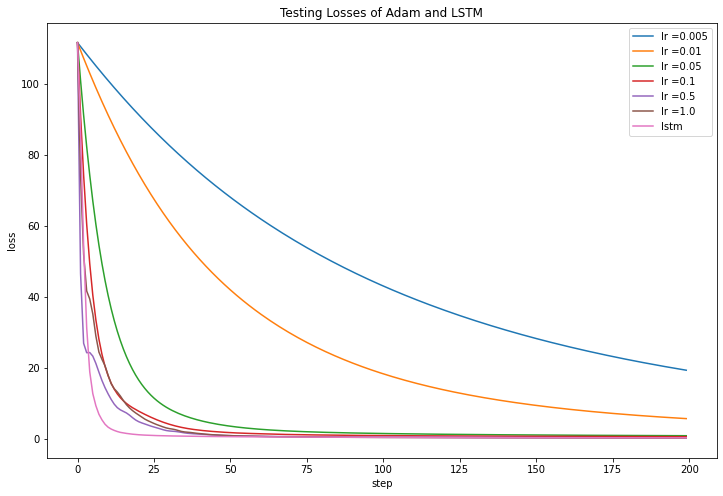

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Testing Losses of Adam and LSTM')
plt.ylabel('loss')
plt.xlabel('step')
for i in range(len(lrs)):
  print('Adam Learning Rate:', lrs[i])
  print('Initial Loss Mean:', quadratic_adam_losses_avgs[i][0])
  print('Final Loss Mean:', quadratic_adam_losses_avgs[i][-1])
  print('-----------------------------')
  plt.plot(quadratic_adam_losses_avgs[i],label= 'lr =' + str(lrs[i]))

print('LSTM')
print('Initial Loss Mean:', quadratic_lstm_losses_avg[0])
print('Final Loss Mean:', quadratic_lstm_losses_avg[-1])
print('-----------------------------')
plt.plot(quadratic_lstm_losses_avg,label= 'lstm')

plt.legend()